In [14]:
import matplotlib.pyplot as plt
import torch
import ase
import numpy as np
import scipy
from ase.build import molecule, bulk, make_supercell
from ase.neighborlist import neighbor_list
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
from torch_nl import compute_neighborlist, compute_neighborlist_n2, ase2data
from torch_nl.timer import timeit

# Periodic systems

##  Metal 

In [3]:
frame = bulk('Si', 'diamond', a=4, cubic=True)
aa = torch.arange(1, 6)
Ps = torch.cartesian_prod(aa,aa,aa)
Ps = Ps[torch.sort(Ps.sum(dim=1)).indices].to(torch.long).numpy()
frames = []
n_atoms = []
for P in Ps:
    frames.append(make_supercell(frame, np.diag(P)))
    n_atoms.append(len(frames[-1]))
n_atoms = np.array(n_atoms)

In [4]:
cutoff = 4

In [5]:
tag = "ASE"
datas = []
for frame in tqdm(frames):
    timing = timeit(neighbor_list, ['ijS', frame, cutoff], tag=tag, warmup=1, nit=50)
    data = timing.dumps()
    i,j,S = neighbor_list('ijS', frame, cutoff)
    n_neighbor = np.bincount(i).mean()
    data.update(n_atom=len(frame), n_neighbor_per_atom_avg=int(n_neighbor))
    data.pop('samples')
    datas.append(data)
# df = pd.DataFrame(datas)

  0%|          | 0/125 [00:00<?, ?it/s]

In [6]:
tags = [
    # "torch_nl O(n^2) CPU", 
    "torch_nl O(n^2) GPU", 
    "torch_nl O(n) CPU", 
    "torch_nl O(n) GPU"
]
for tag in tqdm(tags):
    if "CPU" in tag:
        device = 'cpu'
    elif "GPU" in tag:
        device = 'cuda'
        
    if 'O(n^2)' in tag:
        nl_func = compute_neighborlist_n2
    elif 'O(n)' in tag:
        nl_func = compute_neighborlist

    for frame in tqdm(frames):
        pos, cell, pbc, batch, n_atoms = ase2data([frame], device=device)
        timing = timeit(nl_func, [cutoff, pos, cell, pbc, batch], tag=tag, warmup=10, nit=50)
        data = timing.dumps()
        data.pop('samples')
        mapping, mapping_batch, shifts_idx = nl_func(cutoff, pos, cell, pbc, batch)
        n_neighbor = np.bincount(mapping[0].cpu().numpy()).mean()
        data.update(n_atom=len(frame), n_neighbor_per_atom_avg=int(n_neighbor))
        datas.append(data)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame(datas)

In [8]:
df

,tag,mean,stdev,min,max,n_atom,n_neighbor_per_atom_avg
0,ASE,0.002498,0.000041,0.002439,0.002685,8,28
1,ASE,0.003127,0.000020,0.003101,0.003168,16,28
2,ASE,0.003162,0.000063,0.003101,0.003374,16,28
3,ASE,0.003145,0.000043,0.003100,0.003297,16,28
4,ASE,0.004429,0.000050,0.004374,0.004577,32,28
...,...,...,...,...,...,...,...
495,torch_nl O(n) GPU,0.005046,0.000190,0.004930,0.006348,600,29
496,torch_nl O(n) GPU,0.005924,0.000094,0.005809,0.006476,800,29
497,torch_nl O(n) GPU,0.005886,0.000038,0.005795,0.005943,800,29
498,torch_nl O(n) GPU,0.005913,0.000068,0.005803,0.006292,800,29


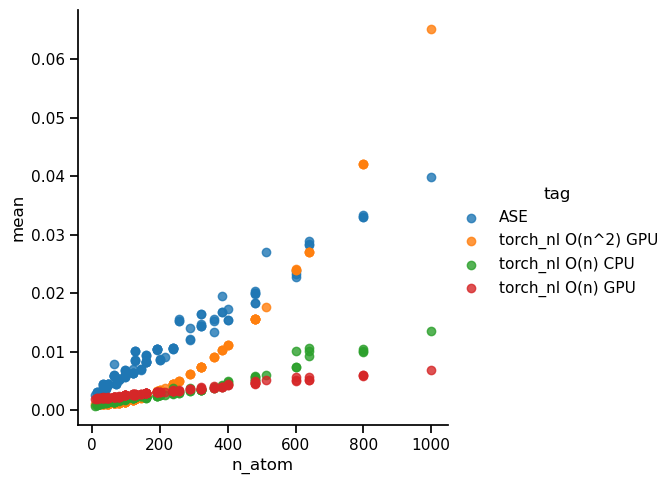

In [16]:
with sns.plotting_context("notebook"):
    plt.title("Compute neighborlist: diamond structure")
    sns.lmplot(data=df, x='n_atom', y='mean', hue='tag',fit_reg=False)
    plt.xlabel('timing []')
    plt.savefig('diamond_benchmark.png', dpi=300, bbox_inches='tight')

In [15]:
plt.savefig?